In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Replace 'path_to_your_file.csv' with the actual path of your CSV file
file_path = '/content/drive/MyDrive/train.csv'

df = pd.read_csv(file_path)

df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


<Axes: title={'center': 'bid_price'}, xlabel='seconds_in_bucket'>

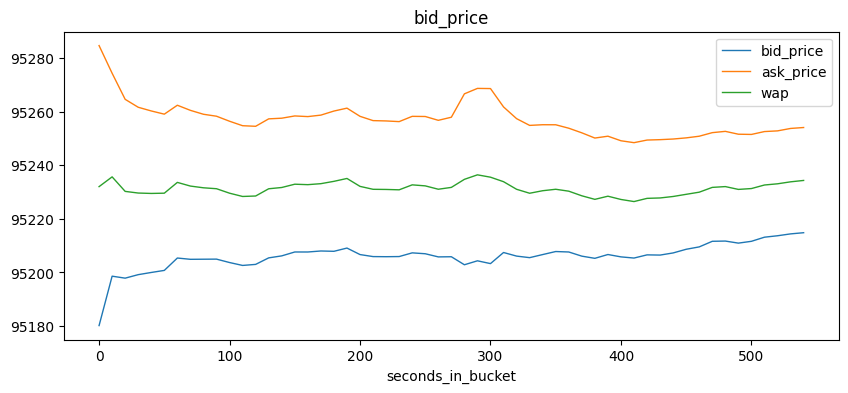

In [4]:
cols = ['bid_price','ask_price', 'wap']
(df.loc[:, ['seconds_in_bucket'] + cols].groupby(['seconds_in_bucket']).sum().plot(title=f'{cols[0]}', figsize=(10, 4), linewidth=1))

<Axes: title={'center': 'far_price'}, xlabel='seconds_in_bucket'>

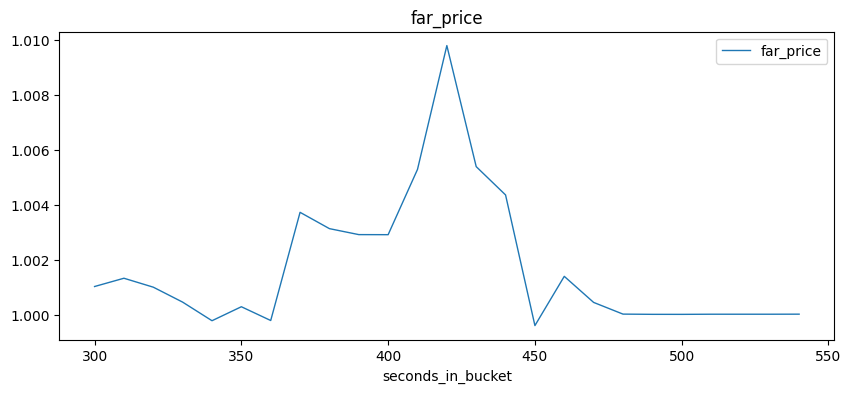

In [5]:
cols = ['far_price']
(df.loc[:, ['seconds_in_bucket'] + cols].groupby(['seconds_in_bucket']).mean().query("seconds_in_bucket>=300").plot(title=f'{cols[0]}', figsize=(10, 4), linewidth=1))

<Axes: title={'center': 'near_price'}, xlabel='seconds_in_bucket'>

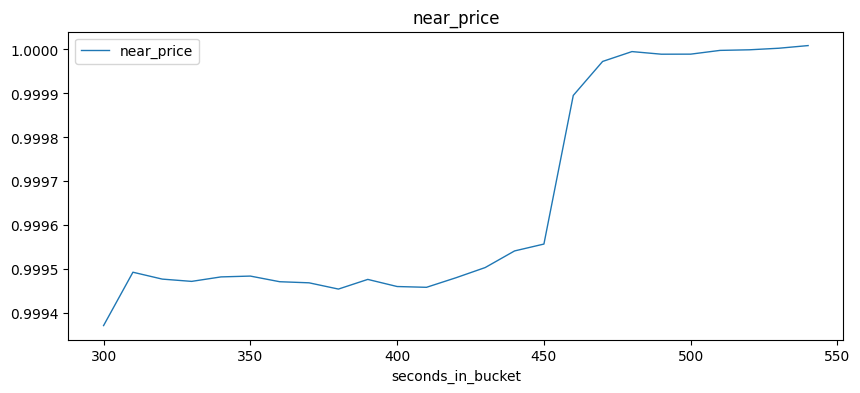

In [6]:
cols = ['near_price']
(df.loc[:, ['seconds_in_bucket'] + cols].groupby(['seconds_in_bucket']).mean().query("seconds_in_bucket>=300").plot(title=f'{cols[0]}', figsize=(10, 4), linewidth=1))

In [7]:
# Count Null values in each column
nan_counts = df.isna().sum()

# Print the count of Null values for each column
print("Count of NaN values in each column:")
print(nan_counts[nan_counts > 0])

Count of NaN values in each column:
imbalance_size         220
reference_price        220
matched_size           220
far_price          2894342
near_price         2857180
bid_price              220
ask_price              220
wap                    220
target                  88
dtype: int64


Predictive Imputation to handle missing data.

In [8]:
#correlation matrix
corr_matrix = df.corr()

#'far_price' and 'near_price'
print(corr_matrix[['far_price', 'near_price']].sort_values(by='far_price', ascending=False))

                         far_price  near_price
far_price                 1.000000    0.031519
near_price                0.031519    1.000000
imbalance_buy_sell_flag   0.018010    0.508853
reference_price           0.015349    0.473595
ask_price                 0.014671    0.460380
wap                       0.014643    0.462579
bid_price                 0.014327    0.458373
bid_size                  0.002229    0.032190
imbalance_size            0.000523   -0.030932
ask_size                 -0.000153   -0.013298
seconds_in_bucket        -0.000550    0.017627
matched_size             -0.000705   -0.002722
stock_id                 -0.000831    0.004736
row_id                   -0.001236   -0.005470
target                   -0.001804    0.006045
date_id                  -0.003004   -0.016150
time_id                  -0.003005   -0.016133


The correlations presented suggest that near_price might have a more significant (yet moderate) relationship with market dynamics indicators such as the imbalance_buy_sell_flag and various pricing features compared to far_price. Far_price appears to be more isolated, showing very weak correlations with all other features in the dataset.

In [9]:
# Print the correlation matrix
print(corr_matrix.loc[['far_price', 'near_price'], ['imbalance_buy_sell_flag', 'reference_price', 'ask_price', 'wap', 'bid_price']])

# Separate the data into sets where 'far_price' and 'near_price' that are not null
train_far = df[df['far_price'].notna()]
train_near = df[df['near_price'].notna()]

# DataFrames where 'far_price' and 'near_price' that are null
predict_far = df[df['far_price'].isna()]
predict_near = df[df['near_price'].isna()]

            imbalance_buy_sell_flag  reference_price  ask_price       wap  \
far_price                  0.018010         0.015349   0.014671  0.014643   
near_price                 0.508853         0.473595   0.460380  0.462579   

            bid_price  
far_price    0.014327  
near_price   0.458373  


Model Building for Far Price

In [10]:
df['ask_price'].fillna(df['ask_price'].mean(), inplace=True)
df['bid_price'].fillna(df['bid_price'].mean(), inplace=True)

In [11]:
# DataFrames for training models (excluding rows with NaN in 'far_price' or 'near_price')
train_far = df[df['far_price'].notna()]
predict_far = df[df['far_price'].isna()]

# Features for prediction (you can choose different or more features based on your correlation analysis)
features = ['ask_price', 'bid_price']

# Initialize the Linear Regression model
model_far = LinearRegression()

# Split data for evaluating model accuracy
X_train_far, X_test_far, y_train_far, y_test_far = train_test_split(
    train_far[features], train_far['far_price'], test_size=0.2, random_state=42)

# Train the model
model_far.fit(X_train_far, y_train_far)

# Validate the model
far_price_pred = model_far.predict(X_test_far)
print(f"Mean Squared Error for 'far_price' model: {mean_squared_error(y_test_far, far_price_pred)}")

# Predicting missing 'far_price' values
predicted_far_values = model_far.predict(predict_far[features])
predict_far['far_price'] = predicted_far_values  # Fill in the missing values


Mean Squared Error for 'far_price' model: 0.7979182878787235


<ipython-input-11-0bea1355a831>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_far['far_price'] = predicted_far_values  # Fill in the missing values


In [12]:
# Repeat the process for 'near_price'
train_near = df[df['near_price'].notna()]
predict_near = df[df['near_price'].isna()]

# Initialize the Linear Regression model
model_near = LinearRegression()

# Split data for evaluating model accuracy
X_train_near, X_test_near, y_train_near, y_test_near = train_test_split(
    train_near[features], train_near['near_price'], test_size=0.2, random_state=42)

# Train the model
model_near.fit(X_train_near, y_train_near)

# Validate the model
near_price_pred = model_near.predict(X_test_near)
print(f"Mean Squared Error for 'near_price' model: {mean_squared_error(y_test_near, near_price_pred)}")

# Predicting missing 'near_price' values
predicted_near_values = model_near.predict(predict_near[features])
predict_near['near_price'] = predicted_near_values  # Fill in the missing values


Mean Squared Error for 'near_price' model: 0.00011573520403320674


<ipython-input-12-5721bed2d3e4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_near['near_price'] = predicted_near_values  # Fill in the missing values


In [13]:
# Combine the modified rows back into the original dataframe
df.loc[predict_far.index, 'far_price'] = predict_far['far_price']
df.loc[predict_near.index, 'near_price'] = predict_near['near_price']


In [14]:
# Median imputation for 'imbalance_size', 'reference_price', 'matched_size', 'wap'
df['imbalance_size'].fillna(df['imbalance_size'].median(), inplace=True)
df['reference_price'].fillna(df['reference_price'].median(), inplace=True)
df['matched_size'].fillna(df['matched_size'].median(), inplace=True)
df['wap'].fillna(df['wap'].median(), inplace=True)

In [15]:
# Dropping rows where 'target' is NaN
df.dropna(subset=['target'], inplace=True)

In [16]:
# Count NaN values in each column
nan_counts = df.isna().sum()
nan_counts

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

Feature Engineering

Feature Selection

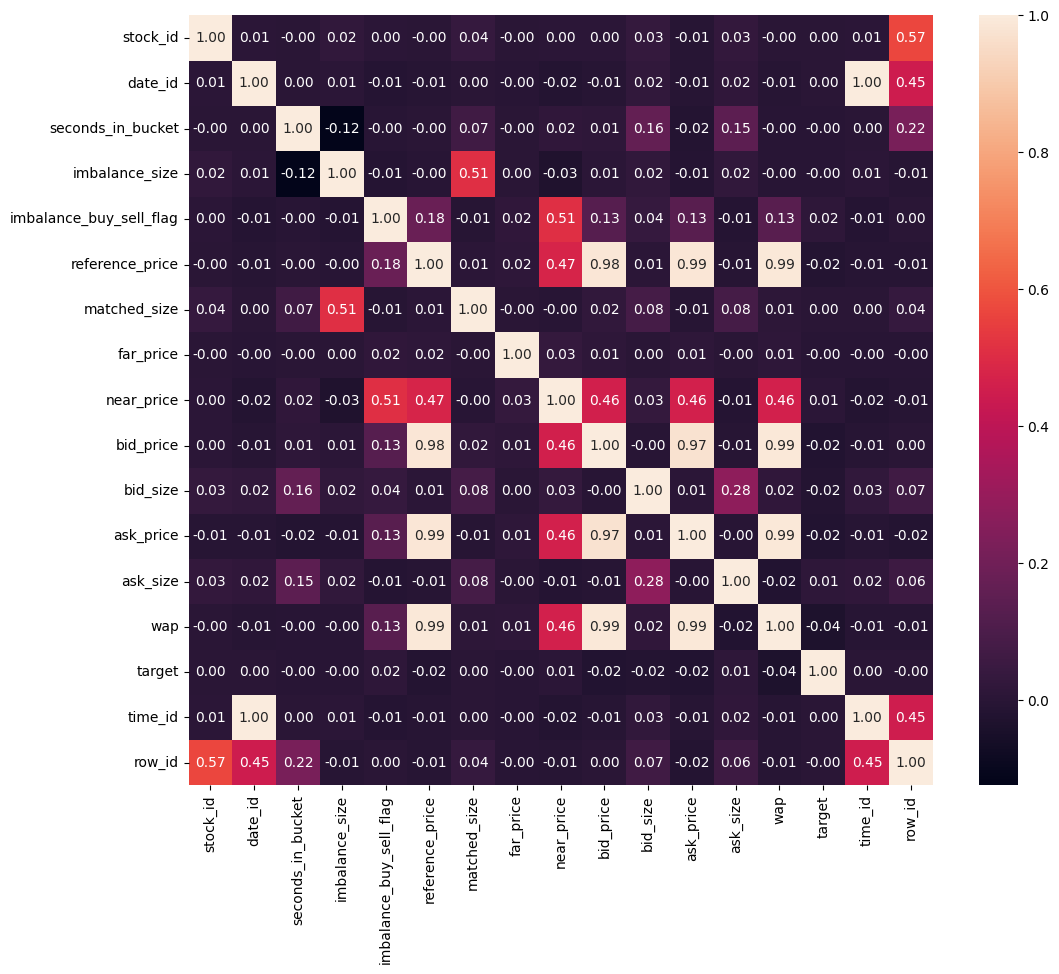

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate and plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

In [18]:
pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.3 MB/s eta 0:00:00


In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define your features and target variable
X = df.drop(['target', 'row_id', 'time_id', 'date_id', 'stock_id'], axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Create the LightGBM data containers
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set the parameters for the model
params = {
    'boosting_type': 'gbdt',  # Traditional Gradient Boosting Decision Tree
    'objective': 'regression',  # Specify the training task
    'metric': {'l2','l1'},  # Evaluate model performance with L2 (RMSE) and L1 (MAE) loss
    'num_leaves': 31,  # Number of leaves in full trees
    'learning_rate': 0.05,  # How much models learns with each iteration
    'feature_fraction': 0.9,  # The fraction of features to use at each iteration (random selection)
    'bagging_fraction': 0.8,  # Fraction of data to use in each iteration (random selection)
    'bagging_freq': 5,  # Perform bagging every 5 iterations
    'verbose': 0  # Control the level of LightGBM's verbosity (0 is silent)
}

# Train the model
num_round = 100  # Number of boosting rounds
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])


In [21]:
# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 86.55533649441867
R^2 Score: 0.028248010062612794


In [22]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

lgb_regressor = lgb.LGBMRegressor(objective='regression', boosting_type='gbdt')

param_grid = {
    'num_leaves': [31,41,51],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 150,200]
}

In [23]:
# Initialize GridSearchCV for hyperparameters tuning
grid_search = GridSearchCV(estimator=lgb_regressor, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1)

# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and their corresponding values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())

print("Best Hyperparameters:", best_hyperparameters)
print("Values:", best_values)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2608
[LightGBM] [Info] Number of data points in the train set: 3352250, number of used features: 12
[LightGBM] [Info] Start training from score -0.044782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2608
[LightGBM] [Info] Number of data points in the train set: 3352250, number of used features: 12
[LightGBM] [Info] Start training from score -0.051042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017633 seconds.
You can set `for

In [24]:
# Initialize and train the LightGBM regressor with the best parameters
final_model1 = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    learning_rate=0.1,
    n_estimators=200,
    num_leaves=51
)

final_model1.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2608
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 12
[LightGBM] [Info] Start training from score -0.047912


LGBMRegressor(n_estimators=200, num_leaves=51, objective='regression')

In [25]:
# Predict on the testing data
y_pred = final_model1.predict(X_test)

# Calculate the mean squared error and R-squared values
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")
print(f"Mean Squared Error: {mse}")

R^2 Score: 0.04665999725058678
Mean Squared Error: 84.9153545205318


                    Feature  Importance
4              matched_size        1443
0         seconds_in_bucket        1156
1            imbalance_size        1126
7                 bid_price         904
6                near_price         822
3           reference_price         762
10                 ask_size         736
8                  bid_size         726
11                      wap         711
9                 ask_price         711
5                 far_price         652
2   imbalance_buy_sell_flag         251


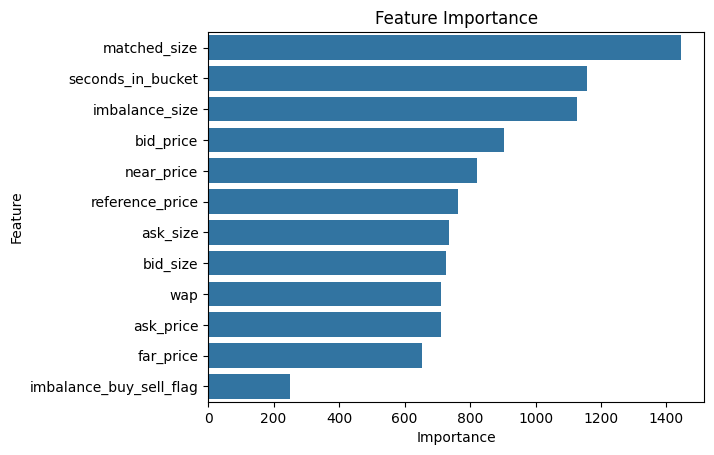

In [26]:
# Feature importance
importance = final_model1.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Optionally, plot the feature importances
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


In [27]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
# Setup cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
# 'neg_mean_squared_error' returns the negative value of the error, so we take the negative of the results to make them positive MSE
scores = -cross_val_score(final_model1, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print results
print("Cross-validated MSE scores:", scores)
print("Average MSE:", np.mean(scores))
print("Standard Deviation of MSE:", np.std(scores))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2608
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 12
[LightGBM] [Info] Start training from score -0.047912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2608
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 12
[LightGBM] [Info] Start training from score -0.045420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [28]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.6 MB/s eta 0:00:00


In [29]:
from catboost import CatBoostRegressor
model2 = CatBoostRegressor(iterations=1000,
                          learning_rate=0.1,
                          depth=3,
                          loss_function='RMSE',
                          verbose=100)

# Train the model
model2.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	learn: 9.4468891	test: 9.4280307	best: 9.4280307 (0)	total: 125ms	remaining: 2m 5s
100:	learn: 9.3558320	test: 9.3398353	best: 9.3398353 (100)	total: 5.49s	remaining: 48.9s
200:	learn: 9.3357457	test: 9.3222540	best: 9.3222540 (200)	total: 10.7s	remaining: 42.5s
300:	learn: 9.3218865	test: 9.3104019	best: 9.3104019 (300)	total: 15.9s	remaining: 36.9s
400:	learn: 9.3116100	test: 9.3014960	best: 9.3014960 (400)	total: 21.1s	remaining: 31.4s
500:	learn: 9.3030222	test: 9.2944541	best: 9.2944541 (500)	total: 26.2s	remaining: 26.1s
600:	learn: 9.2958205	test: 9.2887623	best: 9.2887623 (600)	total: 31.4s	remaining: 20.8s
700:	learn: 9.2895002	test: 9.2841630	best: 9.2841630 (700)	total: 36.5s	remaining: 15.6s
800:	learn: 9.2836999	test: 9.2797596	best: 9.2797596 (800)	total: 41.7s	remaining: 10.4s
900:	learn: 9.2785885	test: 9.2759934	best: 9.2759934 (900)	total: 46.9s	remaining: 5.15s
999:	learn: 9.2739670	test: 9.2721110	best: 9.2720334 (997)	total: 52s	remaining: 0us

bestTest = 9.2720

In [30]:
# Make predictions
y_pred = model2.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 85.97060312355634
R^2 Score: 0.034812779373571634


In [31]:
model2.save_model('model2.bin')

In [32]:
# Get feature importance
feature_importances = model2.get_feature_importance(prettified=True)

# Display feature importance
print(feature_importances)

                 Feature Id  Importances
0                       wap    19.094771
1                  bid_size    13.499255
2                  ask_size    13.279903
3         seconds_in_bucket     9.777346
4           reference_price     7.922063
5                near_price     7.568233
6                 bid_price     6.737327
7                 ask_price     6.531698
8              matched_size     5.778010
9   imbalance_buy_sell_flag     4.492223
10                far_price     2.854693
11           imbalance_size     2.464478


In [33]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'depth': [3, 6, 9],
    'learning_rate': [0.03, 0.1, 0.3],
    'iterations': [500, 1000]
}

# Initialize the regressor
cb_model = CatBoostRegressor(loss_function='RMSE', verbose=0)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ........depth=3, iterations=500, learning_rate=0.03; total time=  17.5s
[CV] END ........depth=3, iterations=500, learning_rate=0.03; total time=  17.3s
[CV] END ........depth=3, iterations=500, learning_rate=0.03; total time=  17.6s
[CV] END .........depth=3, iterations=500, learning_rate=0.1; total time=  17.5s
[CV] END .........depth=3, iterations=500, learning_rate=0.1; total time=  17.6s
[CV] END .........depth=3, iterations=500, learning_rate=0.1; total time=  17.4s
[CV] END .........depth=3, iterations=500, learning_rate=0.3; total time=  17.3s
[CV] END .........depth=3, iterations=500, learning_rate=0.3; total time=  17.4s
[CV] END .........depth=3, iterations=500, learning_rate=0.3; total time=  17.0s
[CV] END .......depth=3, iterations=1000, learning_rate=0.03; total time=  33.6s
[CV] END .......depth=3, iterations=1000, learning_rate=0.03; total time=  33.7s
[CV] END .......depth=3, iterations=1000, learni

In [34]:
best_model.save_model('model1.bin')

In [35]:
# Evaluate the best model
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f'Best Model Mean Squared Error: {mse_best}')
print(f'Best Model R^2 Score: {r2_best}')

Best Model Mean Squared Error: 82.10160066181616
Best Model R^2 Score: 0.07824985666471129


In [36]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.0 MB/s eta 0:00:00


In [37]:
import xgboost as xgb
# Initialize the XGBoost regressor
model3 = xgb.XGBRegressor(objective ='reg:squarederror',   # Use 'reg:squarederror' to avoid outputting a warning for regression
                          colsample_bytree = 0.3,         # Fraction of columns to be randomly samples for each tree
                          learning_rate = 0.1,
                          max_depth = 5,                  # Depth of the tree
                          alpha = 10,                     # L1 regularization term on weights (can help prevent overfitting)
                          n_estimators = 100)             # Number of trees

In [38]:
# Train the model on the training data
model3.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [39]:
# Predict the target on the training and test set
y_train_pred = model3.predict(X_train)
# Calculate the MSE for the training and test sets
mse_train = mean_squared_error(y_train, y_train_pred)
print("Training MSE: {:.2f}".format(mse_train))
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Training MSE: 86.96
R^2 Score: 0.034812779373571634


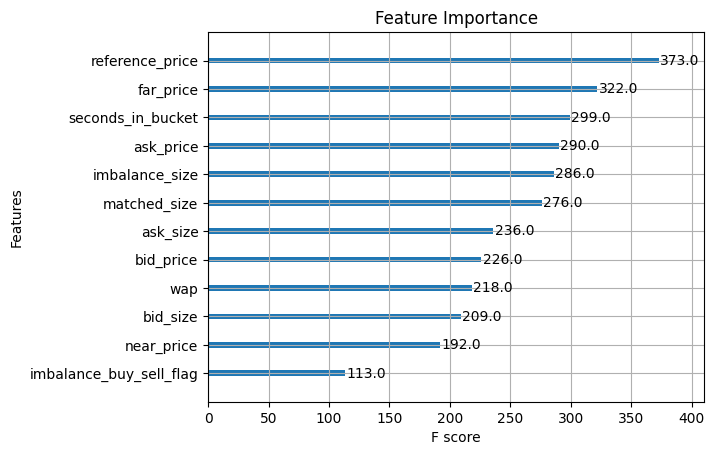

In [40]:
import matplotlib.pyplot as plt

xgb.plot_importance(model3)
plt.title('Feature Importance')
plt.show()

In [41]:
# Setup GridSearchCV
grid_search = GridSearchCV(estimator=model3,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # Change scoring if necessary
                           cv=3,
                           verbose=2,
                           n_jobs=-1)  # Use parallel processing; set to number of cores minus 1

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:54:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "depth", "iterations" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBRegressor(alpha=10, base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.3,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rat...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'depth': [3, 6, 9], 'iterations': [500, 1000],
                         'learning_rate': [0.03, 0.1, 0.3]},
             scoring='neg_mean_squared_error', verbose=2)

In [42]:
# Get the best estimator
best_xgb_model = grid_search.best_estimator_

# Predict on the test set
y_test_pred = best_xgb_model.predict(X_test)

# Calculate MSE
mse_test = mean_squared_error(y_test, y_test_pred)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'depth': 3, 'iterations': 500, 'learning_rate': 0.3}


In [43]:
final_model4 = xgb.XGBRegressor(
    max_depth=3,
    n_estimators=500,
    learning_rate=0.3,
    colsample_bytree=0.7,  # assuming this was part of your original grid
    subsample=1.0,         # assuming this was part of your original grid
    reg_alpha=0,           # assuming no L1 regularization was the best
    reg_lambda=1           # assuming default L2 regularization was the best
)

# Train the model on the full training dataset
final_model4.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
# Predict on the test set
y_test_pred = final_model4.predict(X_test)

# Calculate MSE
mse_test = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", mse_test)
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Test MSE: 85.47702939267185
R^2 Score: 0.034812779373571634


### Testing

In [45]:
file_path = '/content/drive/MyDrive/test.csv'

test_df = pd.read_csv(file_path)

test_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0,False
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.000000,26290,478_0_1,False
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.000000,26290,478_0_2,False
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.000000,26290,478_0_3,False
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.000000,26290,478_0_4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195,False
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196,False
32997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,26454,480_540_197,False
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198,False


In [46]:
# Count Null values in each column
nan_counts = test_df.isna().sum()

# Print the count of Null values for each column
print("Count of NaN values in each column:")
print(nan_counts)

Count of NaN values in each column:
stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                  18229
near_price                 18000
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
time_id                        0
row_id                         0
currently_scored               0
dtype: int64


In [47]:
#correlation matrix
corr_matrix = test_df.corr()

#'far_price' and 'near_price'
print(corr_matrix[['far_price', 'near_price']].sort_values(by='far_price', ascending=False))

                         far_price  near_price
far_price                 1.000000    0.832672
near_price                0.832672    1.000000
imbalance_buy_sell_flag   0.568628    0.544829
reference_price           0.339462    0.429564
ask_price                 0.316117    0.414793
wap                       0.310378    0.413874
bid_price                 0.289803    0.397156
seconds_in_bucket         0.039426    0.077473
bid_size                  0.035264    0.063774
stock_id                  0.029966    0.009130
row_id                    0.011103   -0.007885
matched_size             -0.007852   -0.008660
ask_size                 -0.015582   -0.002045
time_id                  -0.021355   -0.042184
date_id                  -0.027968   -0.055165
imbalance_size           -0.067351   -0.122469
currently_scored               NaN         NaN


In [48]:
# DataFrames for training models (excluding rows with NaN in 'far_price' or 'near_price')
train_far = test_df[test_df['far_price'].notna()]
predict_far = test_df[test_df['far_price'].isna()]

# Features for prediction (you can choose different or more features based on your correlation analysis)
features = ['ask_price', 'bid_price']

# Initialize the Linear Regression model
model_far = LinearRegression()

# Split data for evaluating model accuracy
X_train_far, X_test_far, y_train_far, y_test_far = train_test_split(
    train_far[features], train_far['far_price'], test_size=0.2, random_state=42)

# Train the model
model_far.fit(X_train_far, y_train_far)

# Validate the model
far_price_pred = model_far.predict(X_test_far)
print(f"Mean Squared Error for 'far_price' model: {mean_squared_error(y_test_far, far_price_pred)}")

# Predicting missing 'far_price' values
predicted_far_values = model_far.predict(predict_far[features])
predict_far['far_price'] = predicted_far_values  # Fill in the missing values

Mean Squared Error for 'far_price' model: 0.0004497885286102575


<ipython-input-48-6196f4672232>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_far['far_price'] = predicted_far_values  # Fill in the missing values


In [49]:
# Repeat the process for 'near_price'
train_near = test_df[test_df['near_price'].notna()]
predict_near = test_df[test_df['near_price'].isna()]

# Initialize the Linear Regression model
model_near = LinearRegression()

# Split data for evaluating model accuracy
X_train_near, X_test_near, y_train_near, y_test_near = train_test_split(
    train_near[features], train_near['near_price'], test_size=0.2, random_state=42)

# Train the model
model_near.fit(X_train_near, y_train_near)

# Validate the model
near_price_pred = model_near.predict(X_test_near)
print(f"Mean Squared Error for 'near_price' model: {mean_squared_error(y_test_near, near_price_pred)}")

# Predicting missing 'near_price' values
predicted_near_values = model_near.predict(predict_near[features])
predict_near['near_price'] = predicted_near_values  # Fill in the missing values

Mean Squared Error for 'near_price' model: 0.0001656855405948376


<ipython-input-49-7b0120afe7bf>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_near['near_price'] = predicted_near_values  # Fill in the missing values


In [50]:
# Combine the modified rows back into the original dataframe
test_df.loc[predict_far.index, 'far_price'] = predict_far['far_price']
test_df.loc[predict_near.index, 'near_price'] = predict_near['near_price']

In [51]:
# Count Null values in each column
nan_counts = test_df.isna().sum()

# Print the count of Null values for each column
print("Count of NaN values in each column:")
print(nan_counts)

Count of NaN values in each column:
stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
time_id                    0
row_id                     0
currently_scored           0
dtype: int64


In [52]:
features = ['wap','bid_size','ask_size','seconds_in_bucket','reference_price','near_price','bid_price','ask_price','matched_size','imbalance_buy_sell_flag','far_price','imbalance_size']

In [53]:
predictions = model2.predict(test_df[features])

In [54]:
predictions_df = pd.DataFrame(predictions, columns=['Predicted_Values'])
predictions_df.to_csv('/content/drive/MyDrive/predicted_values.csv', index=False)

predictions_df

,Predicted_Values
0,-2.425696
1,0.942832
2,2.242809
3,-2.387618
4,-2.630242
...,...
32995,-1.571604
32996,-2.126683
32997,0.983742
32998,1.857696


In [55]:
model2.save_model('model2.bin')